# 车辆分类 FastAI 版

## Prerequisites

如果要运行这个笔记本， 您需要安装 fastai 和 pytorch，并将解压好的 VERI-Wild 数据集放置在 `datasets/car_classification/images` 下，标记数据放在 `datasets/car_classification/` 下。

您需要先运行 `data_preparation.ipynb` 这一个笔记本

## Imports

In [2]:
from fastai.vision.all import *
import json
import torch
import torchvision.transforms as transforms

## 加载数据

### 设定数据路径

In [3]:
DATA = "datasets/car_classification/"
IMAGE_PATH = DATA + "images/"
PLATFORM = "linux"

### 加载标签数据

In [5]:
with open(DATA + "labels.json") as f:
    labels = json.load(f)

### 定义从图像名称获取标签的函数

In [6]:
def get_label(x):
    return labels[x.split('.')[0]].strip()

### 加载图像数据，验证集比例设为 20%， 输入尺寸为 224 * 224

In [5]:
dls = ImageDataLoaders.from_name_func(
    IMAGE_PATH, get_image_files(IMAGE_PATH), valid_pct=0.2, seed=42, bs=32,
    label_func=get_label, item_tfms=Resize(224))

### 使用 Nvidia CUDA 进行 GPU 计算

In [6]:
dls = dls.cuda()

### 显示一批样本

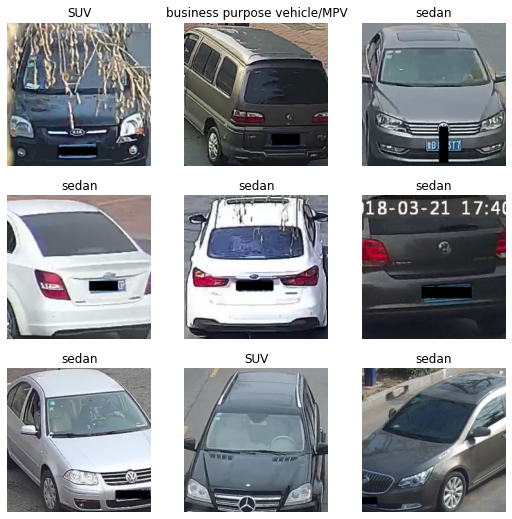

In [7]:
dls.show_batch()

## 模型训练

### 使用 CNN Learner 和 ResNet34 进行迁移学习

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

/home/kxxt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.301233,0.228615,0.071641,54:51


epoch,train_loss,valid_loss,error_rate,time
0,0.079274,0.070100,0.019649,1:11:54


### Save Model

In [11]:
learn.save(f'../../../../models-{PLATFORM}/car_classification_model.ckpt')

Path('datasets/car_classification/images/models/../../../../models-linux/car_classification_model.ckpt.pth')

## 检查训练结果

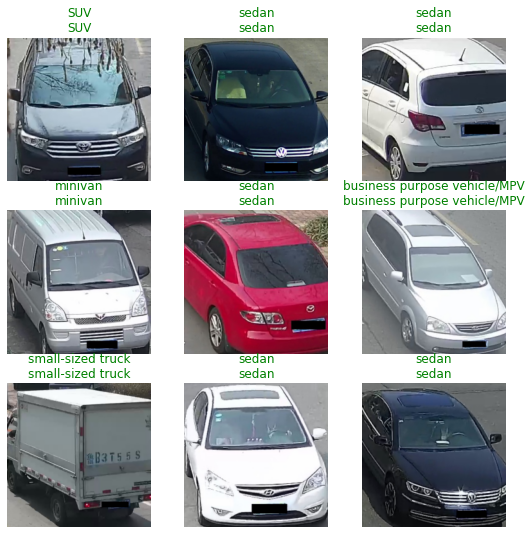

In [13]:
learn.show_results()

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

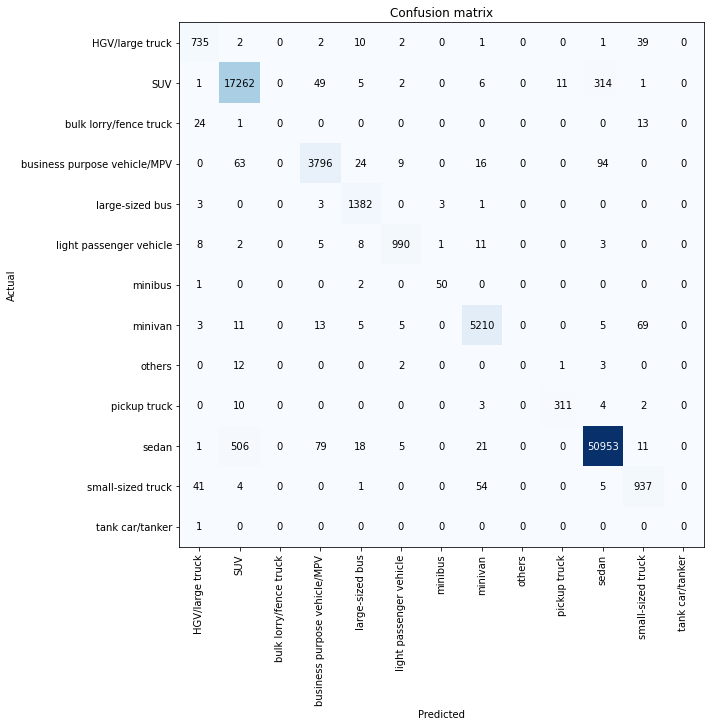

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
cm = interp.plot_confusion_matrix()

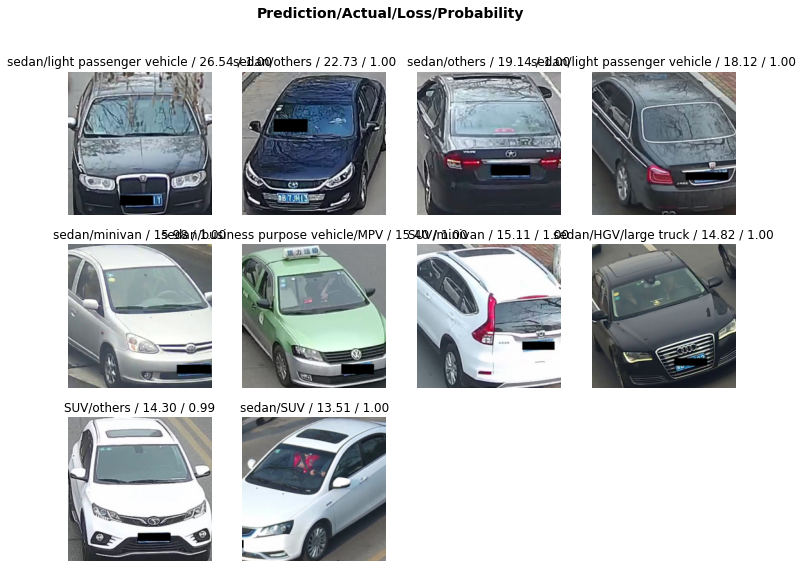

In [23]:
interp.plot_top_losses(10)

In [18]:
interp.most_confused()

[('sedan', 'SUV', 506),
 ('SUV', 'sedan', 314),
 ('business purpose vehicle/MPV', 'sedan', 94),
 ('sedan', 'business purpose vehicle/MPV', 79),
 ('minivan', 'small-sized truck', 69),
 ('business purpose vehicle/MPV', 'SUV', 63),
 ('small-sized truck', 'minivan', 54),
 ('SUV', 'business purpose vehicle/MPV', 49),
 ('small-sized truck', 'HGV/large truck', 41),
 ('HGV/large truck', 'small-sized truck', 39),
 ('bulk lorry/fence truck', 'HGV/large truck', 24),
 ('business purpose vehicle/MPV', 'large-sized bus', 24),
 ('sedan', 'minivan', 21),
 ('sedan', 'large-sized bus', 18),
 ('business purpose vehicle/MPV', 'minivan', 16),
 ('bulk lorry/fence truck', 'small-sized truck', 13),
 ('minivan', 'business purpose vehicle/MPV', 13),
 ('others', 'SUV', 12),
 ('SUV', 'pickup truck', 11),
 ('light passenger vehicle', 'minivan', 11),
 ('minivan', 'SUV', 11),
 ('sedan', 'small-sized truck', 11),
 ('HGV/large truck', 'large-sized bus', 10),
 ('pickup truck', 'SUV', 10),
 ('business purpose vehicle/MP

In [21]:
interp.print_classification_report()

                              precision    recall  f1-score   support

             HGV/large truck       0.90      0.93      0.91       792
                         SUV       0.97      0.98      0.97     17651
      bulk lorry/fence truck       0.00      0.00      0.00        38
business purpose vehicle/MPV       0.96      0.95      0.96      4002
             large-sized bus       0.95      0.99      0.97      1392
     light passenger vehicle       0.98      0.96      0.97      1028
                     minibus       0.93      0.94      0.93        53
                     minivan       0.98      0.98      0.98      5321
                      others       0.00      0.00      0.00        18
                pickup truck       0.96      0.94      0.95       330
                       sedan       0.99      0.99      0.99     51594
           small-sized truck       0.87      0.90      0.89      1042
             tank car/tanker       0.00      0.00      0.00         1

                  

/home/kxxt/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kxxt/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kxxt/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 模型导出

### Save the model as fastai pickle format and onnx format

In [25]:
learn.export(f"../../../models-{PLATFORM}/car_classification_model.pkl")
torch_model = learn.model.eval()
# define softmax layer
softmax_layer = torch.nn.Softmax(dim=1).cuda()
# define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).cuda()
# assemble the final model
final_model = nn.Sequential(
    normalization_layer,
    torch_model,
    softmax_layer
)

# Export onnx model generated by pytorch
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 224, 224).cuda(),
    'models/car_classification_model.onnx',
    do_constant_folding=True,
    export_params=True,
    input_names=['image_1_3_224_224'],
    output_names=['car_category'],
    opset_version=11
)

### Save the label string <=> integer map

In [49]:
with open(f"models-{PLATFORM}/car_classification_model.labels","w") as f:
    json.dump(learn.dls.vocab.o2i,f)

## Model Forecast

### Load learner

In [7]:
learn_inf = load_learner(f"models-{PLATFORM}/car_classification_model.pkl")

### Create a button for image upload

In [8]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

### Forecast the uploaded image

Category: sedan, id:10, probs:tensor([4.0868e-04, 4.1889e-03, 2.5253e-04, 3.8390e-02, 3.6576e-03, 5.8300e-04,
        1.9028e-04, 6.4627e-03, 7.7218e-05, 3.8923e-04, 9.4508e-01, 3.0906e-04,
        1.2307e-05])


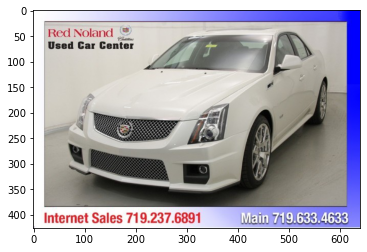

In [11]:
img = PILImage.create(btn_upload.data[-1])
plt.imshow(img)
pred,pred_idx,probs = learn_inf.predict(img)
print(f"Category: {pred}, id:{pred_idx}, probs:{probs}")